### MLS Data Visualization

Last modified: 10/12/2023

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore", module = "seaborn")

# 3rd party libraries
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Local imports
from mls_stats import Team, league_stats

In [2]:
def round_to_next_five(number: int) -> int:
    return (5 * (round(number/5 +1)))

Forward Passing Accuracy Stripplot (STL v. CIN)

In [3]:
stl = Team('STL', 'St. Louis City SC', 17012, '#ec1458', '#001544', '#fed500')
cin = Team('CIN', 'FC Cincinnati', 11504, '#003087', '#fe5000', '#0b1f41')
stl_df = stl.get_stats()
cin_df = cin.get_stats()
assert (stl_df is not None) and (cin_df is not None)
joint_stats = pd.concat([stl_df.all, cin_df.all], ignore_index=True)

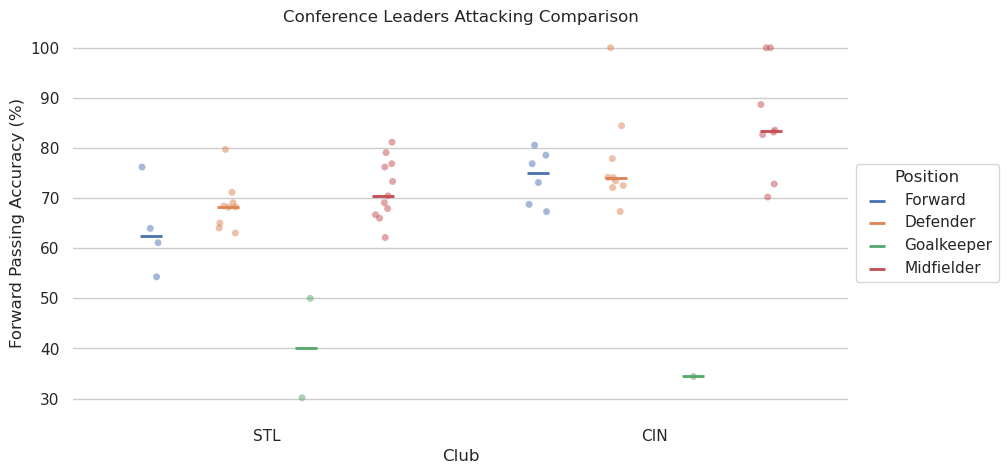

In [4]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(bottom=True, left=True)
sns.stripplot(data=joint_stats, x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic', 
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], alpha=0.50, dodge=True, marker='o', legend=False)
pt_lines = sns.pointplot(data=joint_stats,  x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic',
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], dodge=.6, estimator='median', markers='_', linestyles='none', errorbar=None)

for i in range(8, 12): 
    points = pt_lines.collections[i]
    size= points.get_sizes().item()
    new_sizes=[size*5]
    points.set_sizes(new_sizes)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, title='Position', markerscale=0.75)
ax.set(ylabel='Forward Passing Accuracy (%)', xlabel='Club', title='MLS Conference Leaders Comparison');

Misconduct Bivariate Histogram (League)

In [5]:
mls_players = league_stats(2023, 'players')

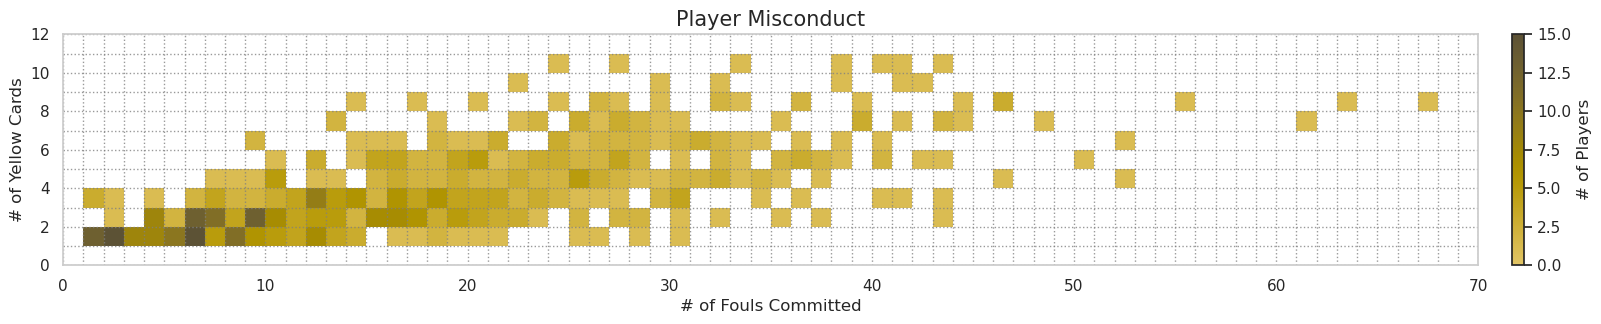

In [6]:
fig, ax = plt.subplots(figsize=(22,3))

sns.set_theme(style='white')
sns.histplot(data=mls_players, x='regular_season_statistics.fk_foul_lost', y='regular_season_statistics.yellow_card', binwidth=1,
             cbar=True, cbar_kws={'label': '# of Players', 'pad': 0.02}, zorder=0, color='gold')
sns.light_palette('goldenrod', as_cmap=True)
ax.set(xlabel='# of Fouls Committed', ylabel='# of Yellow Cards', xlim=(0, 70), ylim=(0, 12))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='major', color='grey', linestyle=':', alpha=0.8)
ax.grid(which='minor', color='grey', linestyle=':', alpha=0.8)
ax.set_title('Player Misconduct', size=15);

Goals Pair Grid (League)

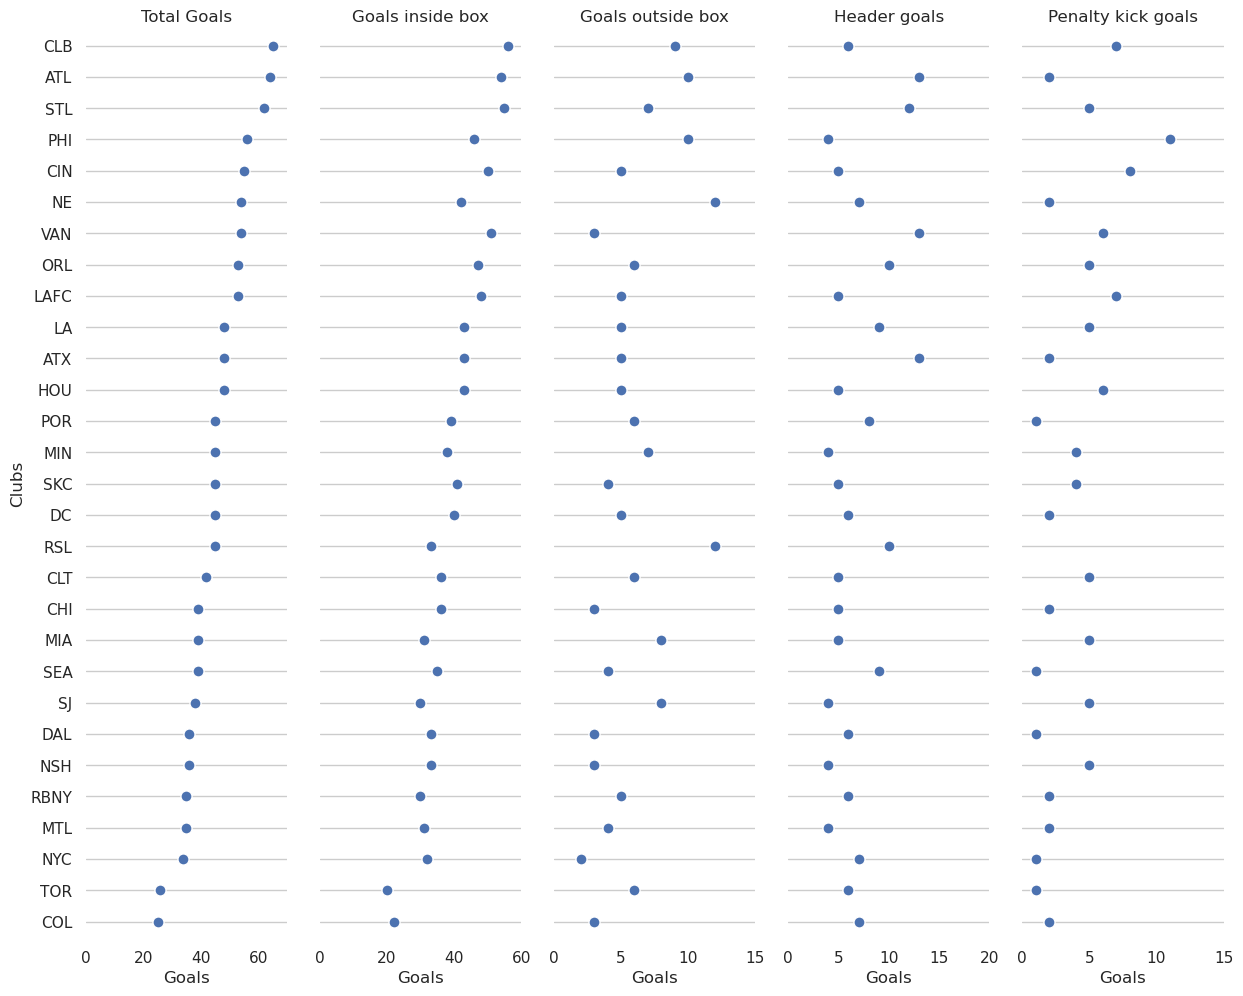

In [7]:
mls_clubs = league_stats(2023, 'clubs')
assert mls_clubs is not None

goal_cols = ['regular_season_statistics.goals', 'regular_season_statistics.att_ibox_goal', 'regular_season_statistics.att_obox_goal', 
             'regular_season_statistics.att_hd_goal', 'regular_season_statistics.att_pen_goal']

g = sns.PairGrid(mls_clubs.sort_values(by='regular_season_statistics.goals', ascending=False),
                 x_vars=goal_cols,
                 y_vars=['club.abbreviation'], height=10, aspect=.25)

g.map(sns.stripplot, size=8, orient='h', jitter=False, palette='flare_r', linewidth=1, edgecolor='w')
g.set(xlabel='Goals', ylabel='Clubs')

titles = ["Total Goals", "Goals inside box", "Goals outside box",
          "Header goals", "Penalty kick goals"]

for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):

    # Set a different title for each axes
    ax.set(title=title, xlim=(0, round_to_next_five(mls_clubs[goal_cols[i]].max())))

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Win-Draw-Loss Record Since 2000 (SKC)

In [8]:
skc = Team('SKC', 'Sporting Kansas City', 421, '#0c2340', '#a5bad6', '#878b8c')
wins = []
draws = []
losses = []

for i in range(2000, 2023):     # draws were only introduced to rules in 2000
    league_df = league_stats(i, 'clubs')
    assert league_df is not None
    skc_df = league_df[league_df['club.abbreviation'] == 'SKC']
    wins.append(skc_df['regular_season_statistics.total_wins'].loc[skc_df.index[0]])
    draws.append(skc_df['regular_season_statistics.total_draws'].loc[skc_df.index[0]])
    losses.append(skc_df['regular_season_statistics.total_losses'].loc[skc_df.index[0]])

years = np.array(range(2000, 2023))
wdl_stats = {
    'Wins': np.array(wins),
    'Draws': np.array(draws),
    'Losses': np.array(losses),
}

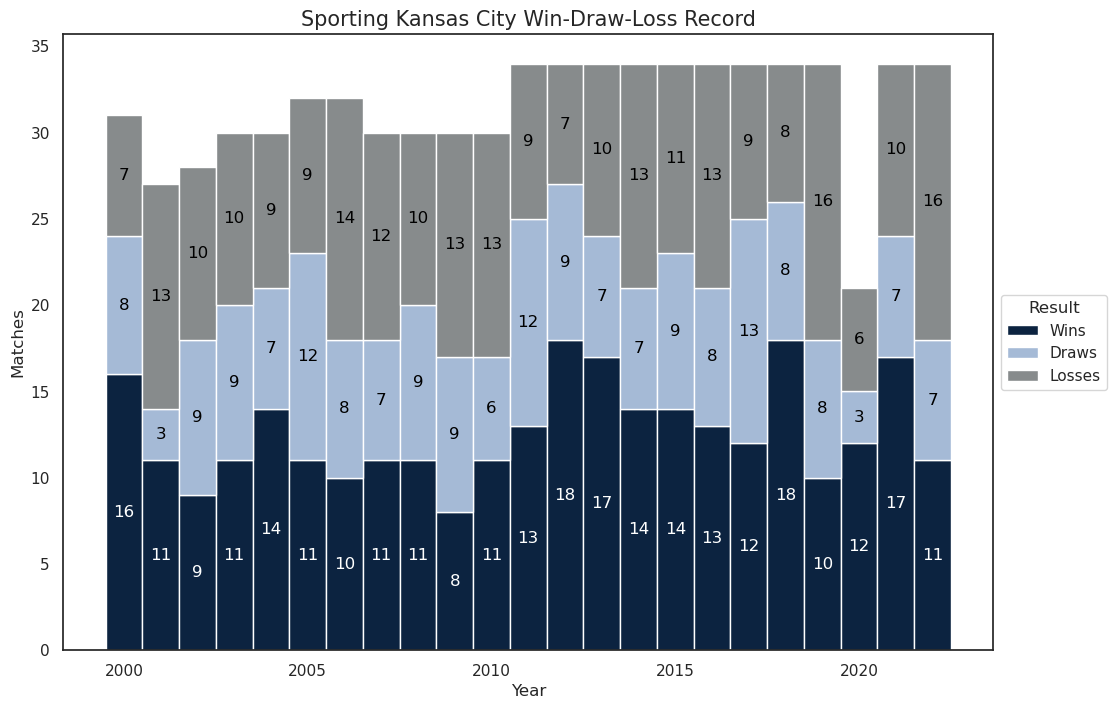

In [9]:
width = 1
bottom = np.zeros(23)

fig, ax = plt.subplots(figsize=(12, 8))
label_cols = ['white', 'black', 'black']
for i, (result, wdl_stat) in enumerate(wdl_stats.items()):
    col_var = f'''skc.color_{i+1}'''
    p = ax.bar(years, wdl_stat, width, label=result, bottom=bottom, color=eval(col_var))
    bottom += wdl_stat

    ax.bar_label(p, label_type='center', color=label_cols[i])

ax.legend(title='Result', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Year', ylabel='Matches')
ax.set_title('Sporting Kansas City Win-Draw-Loss Record', size=15);

Correlation Matrix Heatmaps

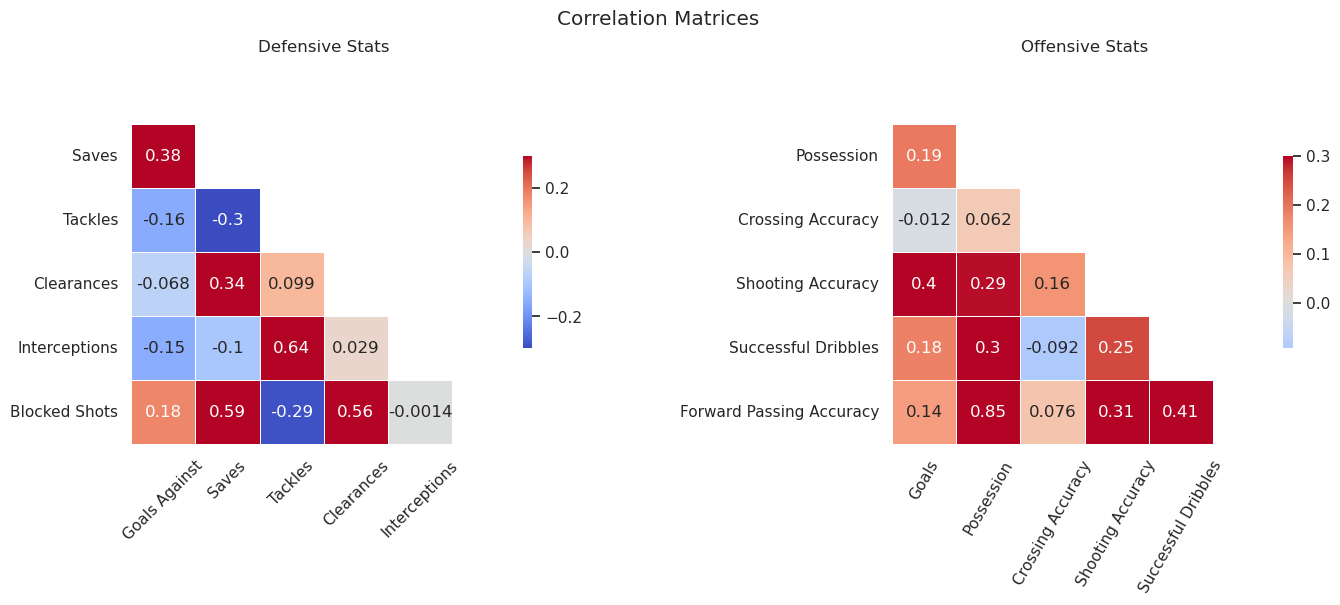

In [10]:
assert mls_clubs is not None

# Make defensive dataframe
defend_df = pd.DataFrame({'Goals Against': mls_clubs['regular_season_statistics.goals_conceded'], 'Saves': mls_clubs['regular_season_statistics.saves'], 
                          'Tackles': mls_clubs['regular_season_statistics.won_tackle'], 'Clearances': mls_clubs['regular_season_statistics.total_clearance'],
                          'Interceptions': mls_clubs['regular_season_statistics.interception'], 'Blocked Shots': mls_clubs['regular_season_statistics.outfielder_block']})

# Construct passing/offensive dataframe
attack_df = pd.DataFrame({'Goals': mls_clubs['regular_season_statistics.goals'], 'Possession': mls_clubs['regular_season_statistics.possession_percentage'],
                          'Crossing Accuracy': mls_clubs['regular_season_statistics.accurate_cross_per'], 'Shooting Accuracy': mls_clubs['regular_season_statistics.accurate_shooting_per'], 
                          'Successful Dribbles': mls_clubs['regular_season_statistics.successful_dribble'], 'Forward Passing Accuracy': mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']})

# Plot correlation matrices
def_corr = defend_df.corr()
def_mask = np.triu(np.ones_like(def_corr, dtype=bool))
att_corr = attack_df.corr()
att_mask = np.triu(np.ones_like(att_corr, dtype=bool))     # create mask for upper right

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
cmap = sns.color_palette('coolwarm', as_cmap=True)
sns.heatmap(def_corr, mask=def_mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, 'pad': 0.01}, ax=axes[0])
axes[0].set(title='Defensive Stats')
axes[0].set_xticks(axes[0].get_xticks()[0:5], axes[0].get_xticklabels()[0:5], rotation=45)
axes[0].set_yticks(axes[0].get_yticks()[1:6], axes[0].get_yticklabels()[1:6])

sns.heatmap(att_corr, mask=att_mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, 'pad': 0.01}, ax=axes[1])
axes[1].set(title='Offensive Stats')
axes[1].set_xticks(axes[1].get_xticks()[0:5], axes[1].get_xticklabels()[0:5], rotation=60)
axes[1].set_yticks(axes[1].get_yticks()[1:6], axes[1].get_yticklabels()[1:6])

f.suptitle('Correlation Matrices');

Linear Regression Analysis

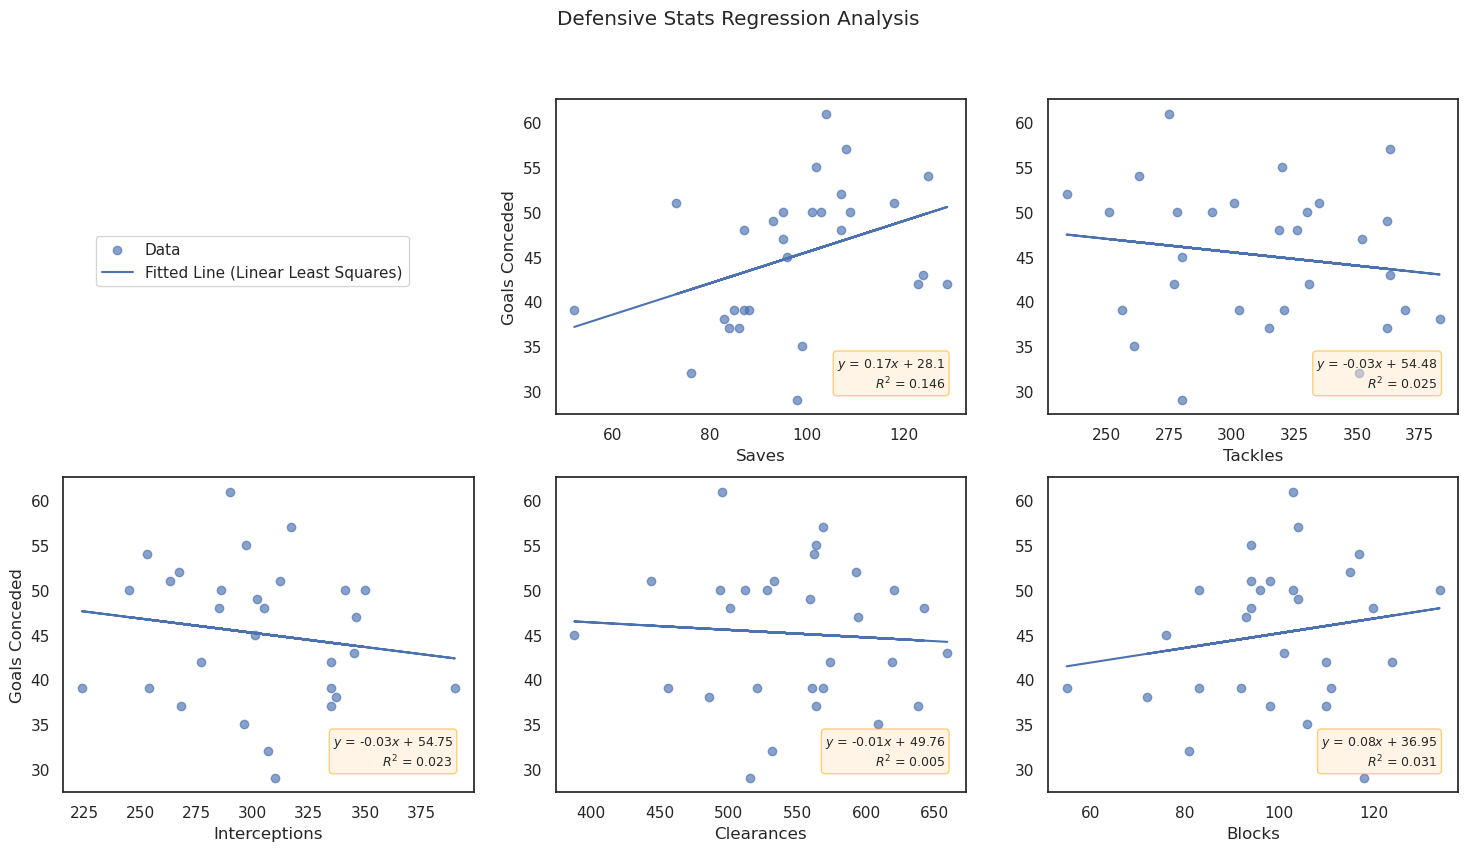

In [11]:
assert mls_clubs is not None
def_res1 = stats.linregress(mls_clubs['regular_season_statistics.saves'], mls_clubs['regular_season_statistics.goals_conceded'])
def_res2 = stats.linregress(mls_clubs['regular_season_statistics.won_tackle'], mls_clubs['regular_season_statistics.goals_conceded'])
def_res3 = stats.linregress(mls_clubs['regular_season_statistics.interception'], mls_clubs['regular_season_statistics.goals_conceded'])
def_res4 = stats.linregress(mls_clubs['regular_season_statistics.total_clearance'], mls_clubs['regular_season_statistics.goals_conceded'])
def_res5 = stats.linregress(mls_clubs['regular_season_statistics.outfielder_block'], mls_clubs['regular_season_statistics.goals_conceded'])

fig = plt.figure(figsize=(18, 9), constrained_layout=False)
gs = gridspec.GridSpec(2, 3, figure=fig)

# Saves plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(mls_clubs['regular_season_statistics.saves'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66)
ax1.plot(mls_clubs['regular_season_statistics.saves'], (def_res1.intercept + def_res1.slope * mls_clubs['regular_season_statistics.saves']))
corr_stats = (f'$y$ = {round(def_res1.slope, 2)}$x$ + {round(def_res1.intercept, 2)}\n'
              f'$R^2$ = {round(def_res1.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax1.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax1.transAxes, horizontalalignment='right')
ax1.set(xlabel='Saves', ylabel='Goals Conceded');

# Tackles plot
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(mls_clubs['regular_season_statistics.won_tackle'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66, label='Data')
ax2.plot(mls_clubs['regular_season_statistics.won_tackle'], (def_res2.intercept + def_res2.slope * mls_clubs['regular_season_statistics.won_tackle']), label='Fitted Line (Linear Least Squares)')
corr_stats = (f'$y$ = {round(def_res2.slope, 2)}$x$ + {round(def_res2.intercept, 2)}\n'
              f'$R^2$ = {round(def_res2.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax2.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax2.transAxes, horizontalalignment='right')
ax2.set(xlabel='Tackles');

# Interception plot
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(mls_clubs['regular_season_statistics.interception'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66)
ax3.plot(mls_clubs['regular_season_statistics.interception'], (def_res3.intercept + def_res3.slope * mls_clubs['regular_season_statistics.interception']))
corr_stats = (f'$y$ = {round(def_res3.slope, 2)}$x$ + {round(def_res3.intercept, 2)}\n'
              f'$R^2$ = {round(def_res3.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax3.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')
ax3.set(xlabel='Interceptions', ylabel='Goals Conceded');

# Clearance plot
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(mls_clubs['regular_season_statistics.total_clearance'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66)
ax4.plot(mls_clubs['regular_season_statistics.total_clearance'], (def_res4.intercept + def_res4.slope * mls_clubs['regular_season_statistics.total_clearance']))
corr_stats = (f'$y$ = {round(def_res4.slope, 2)}$x$ + {round(def_res4.intercept, 2)}\n'
              f'$R^2$ = {round(def_res4.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax4.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax4.transAxes, horizontalalignment='right')
ax4.set(xlabel='Clearances');

# Blocks plot
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(mls_clubs['regular_season_statistics.outfielder_block'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66)
ax5.plot(mls_clubs['regular_season_statistics.outfielder_block'], (def_res5.intercept + def_res5.slope * mls_clubs['regular_season_statistics.outfielder_block']))
corr_stats = (f'$y$ = {round(def_res5.slope, 2)}$x$ + {round(def_res5.intercept, 2)}\n'
              f'$R^2$ = {round(def_res5.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax5.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax5.transAxes, horizontalalignment='right')
ax5.set(xlabel='Blocks')

fig.legend(loc='center', bbox_to_anchor=(0.23, 0.7))
fig.suptitle('Defensive Stats Regression Analysis');

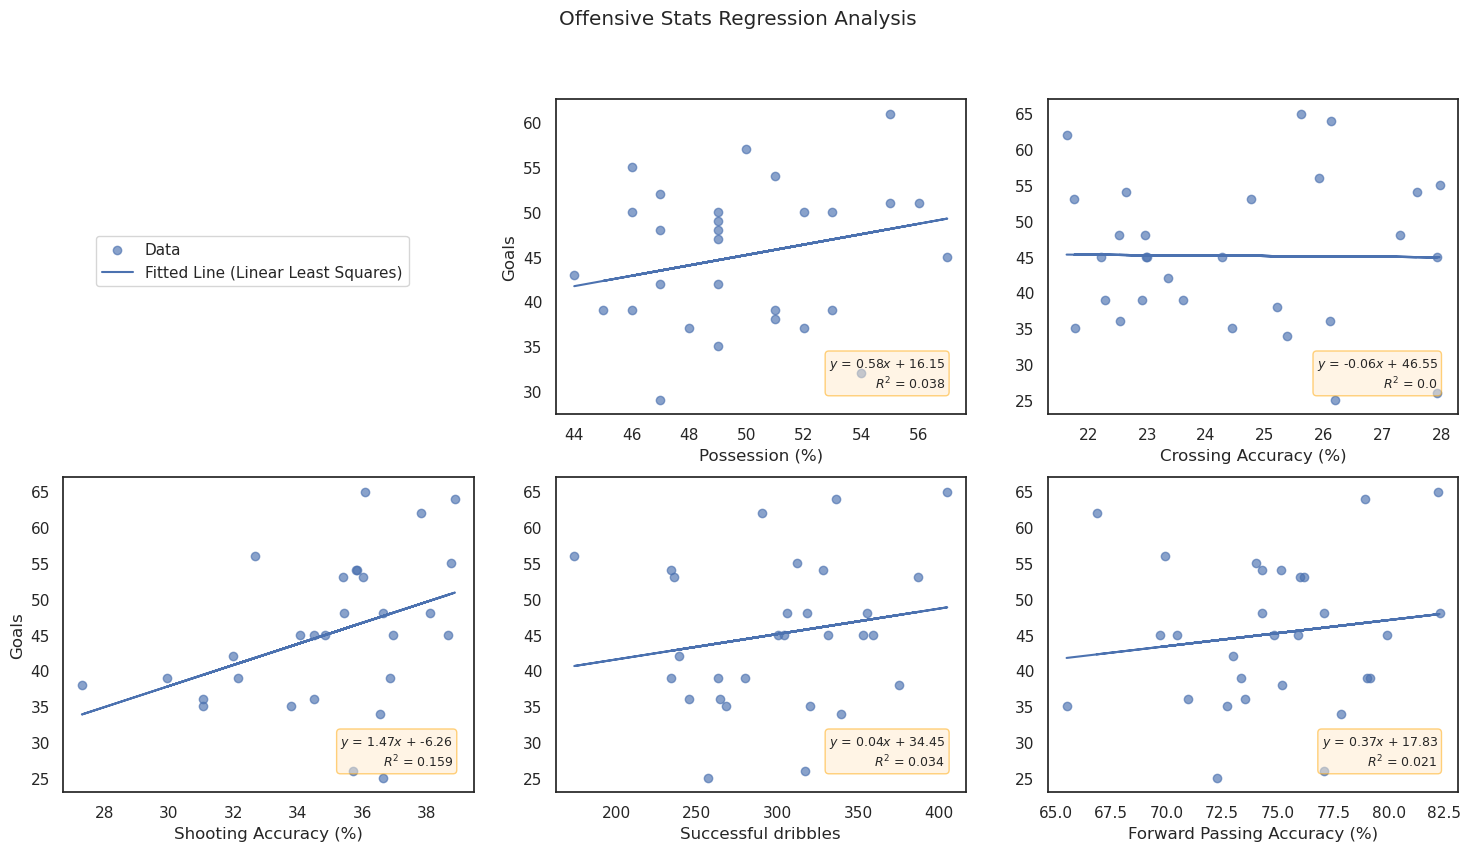

In [12]:
assert mls_clubs is not None

att_res1 = stats.linregress(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals'])
att_res2 = stats.linregress(mls_clubs['regular_season_statistics.accurate_cross_per'], mls_clubs['regular_season_statistics.goals'])
att_res3 = stats.linregress(mls_clubs['regular_season_statistics.accurate_shooting_per'], mls_clubs['regular_season_statistics.goals'])
att_res4 = stats.linregress(mls_clubs['regular_season_statistics.successful_dribble'], mls_clubs['regular_season_statistics.goals'])
att_res5 = stats.linregress(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'])

fig = plt.figure(figsize=(18, 9), constrained_layout=False)
gs = gridspec.GridSpec(2, 3, figure=fig)

# Possession plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals_conceded'], alpha=0.66)
ax1.plot(mls_clubs['regular_season_statistics.possession_percentage'], (att_res1.intercept + att_res1.slope * mls_clubs['regular_season_statistics.possession_percentage']))
corr_stats = (f'$y$ = {round(att_res1.slope, 2)}$x$ + {round(att_res1.intercept, 2)}\n'
              f'$R^2$ = {round(att_res1.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax1.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax1.transAxes, horizontalalignment='right')
ax1.set(xlabel='Possession (%)', ylabel='Goals');

# Crosses plot
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(mls_clubs['regular_season_statistics.accurate_cross_per'], mls_clubs['regular_season_statistics.goals'], alpha=0.66, label='Data')
ax2.plot(mls_clubs['regular_season_statistics.accurate_cross_per'], (att_res2.intercept + att_res2.slope * mls_clubs['regular_season_statistics.accurate_cross_per']), label='Fitted Line (Linear Least Squares)')
corr_stats = (f'$y$ = {round(att_res2.slope, 2)}$x$ + {round(att_res2.intercept, 2)}\n'
              f'$R^2$ = {round(att_res2.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax2.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax2.transAxes, horizontalalignment='right')
ax2.set(xlabel='Crossing Accuracy (%)');

# Shooting plot
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(mls_clubs['regular_season_statistics.accurate_shooting_per'], mls_clubs['regular_season_statistics.goals'], alpha=0.66)
ax3.plot(mls_clubs['regular_season_statistics.accurate_shooting_per'], (att_res3.intercept + att_res3.slope * mls_clubs['regular_season_statistics.accurate_shooting_per']))
corr_stats = (f'$y$ = {round(att_res3.slope, 2)}$x$ + {round(att_res3.intercept, 2)}\n'
              f'$R^2$ = {round(att_res3.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax3.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')
ax3.set(xlabel='Shooting Accuracy (%)', ylabel='Goals');

# Dribbles plot
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(mls_clubs['regular_season_statistics.successful_dribble'], mls_clubs['regular_season_statistics.goals'], alpha=0.66)
ax4.plot(mls_clubs['regular_season_statistics.successful_dribble'], (att_res4.intercept + att_res4.slope * mls_clubs['regular_season_statistics.successful_dribble']))
corr_stats = (f'$y$ = {round(att_res4.slope, 2)}$x$ + {round(att_res4.intercept, 2)}\n'
              f'$R^2$ = {round(att_res4.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax4.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax4.transAxes, horizontalalignment='right')
ax4.set(xlabel='Successful dribbles');

# Forward passing plot
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'], alpha=0.66)
ax5.plot(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], (att_res5.intercept + att_res5.slope * mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']))
corr_stats = (f'$y$ = {round(att_res5.slope, 2)}$x$ + {round(att_res5.intercept, 2)}\n'
              f'$R^2$ = {round(att_res5.rvalue**2, 3)}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax5.text(0.95, 0.08, corr_stats, fontsize=9, bbox=bbox,
        transform=ax5.transAxes, horizontalalignment='right')
ax5.set(xlabel='Forward Passing Accuracy (%)')

fig.legend(loc='center', bbox_to_anchor=(0.23, 0.7))
fig.suptitle('Offensive Stats Regression Analysis');
